In [1]:
!pip install xgboost


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
# Import required models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [3]:
# Load processed data
X = joblib.load('../data/processed/X_processed.joblib')
y = joblib.load('../data/processed/y_processed.joblib')
scaler = joblib.load('../data/processed/scaler.joblib')


# Display data information
print("Features shape:", X.shape)
print("Target distribution:\n", pd.Series(y).value_counts(normalize=True))

Features shape: (41188, 52)
Target distribution:
 y
0.0    0.887346
1.0    0.112654
Name: proportion, dtype: float64


Model Evaluation

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate model performance using multiple metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results = {
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    
    return results

Create dictionary of base models:

In [5]:
# Define base models
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=4.4384)
}

Create train-test split

In [6]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (32950, 52)
Testing set shape: (8238, 52)


Evaluate all base models:

In [7]:
# Evaluate each model
results = {}
for name, model in base_models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)




Evaluating Logistic Regression...


c:\Users\ashut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluating Naive Bayes...

Evaluating KNN...

Evaluating Decision Tree...

Evaluating Random Forest...

Evaluating XGBoost...


In [8]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(3))


Model Comparison:
                     ROC-AUC  Precision  Recall     F1
Logistic Regression    0.942      0.445   0.903  0.596
Naive Bayes            0.859      0.455   0.477  0.466
KNN                    0.891      0.614   0.486  0.542
Decision Tree          0.740      0.527   0.542  0.534
Random Forest          0.942      0.648   0.454  0.534
XGBoost                0.942      0.513   0.824  0.633


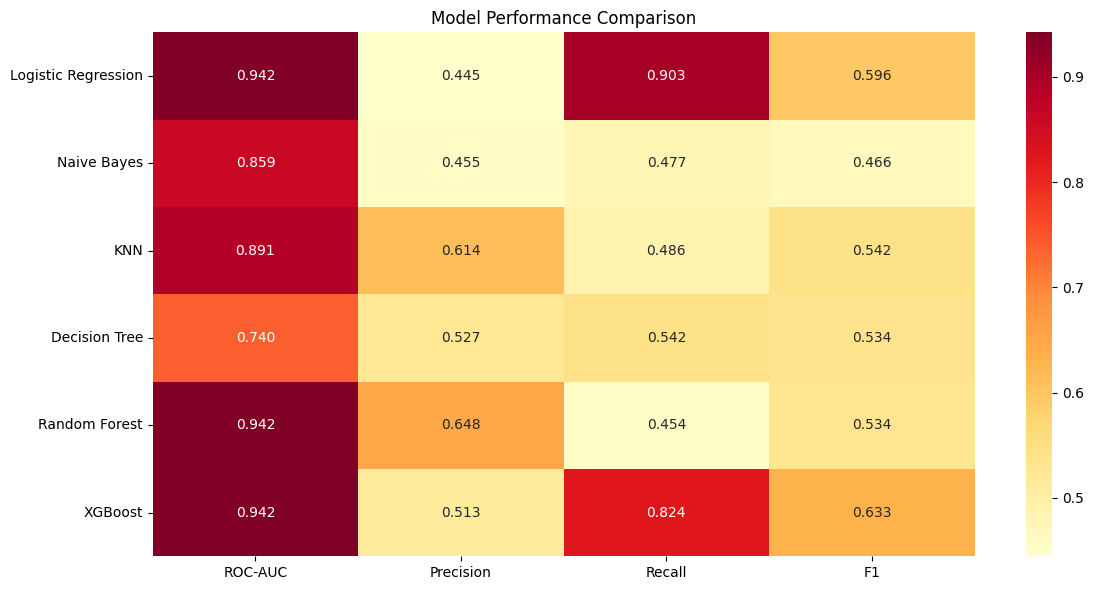

In [9]:
# Visualize results
plt.figure(figsize=(12, 6))
sns.heatmap(results_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

c:\Users\ashut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


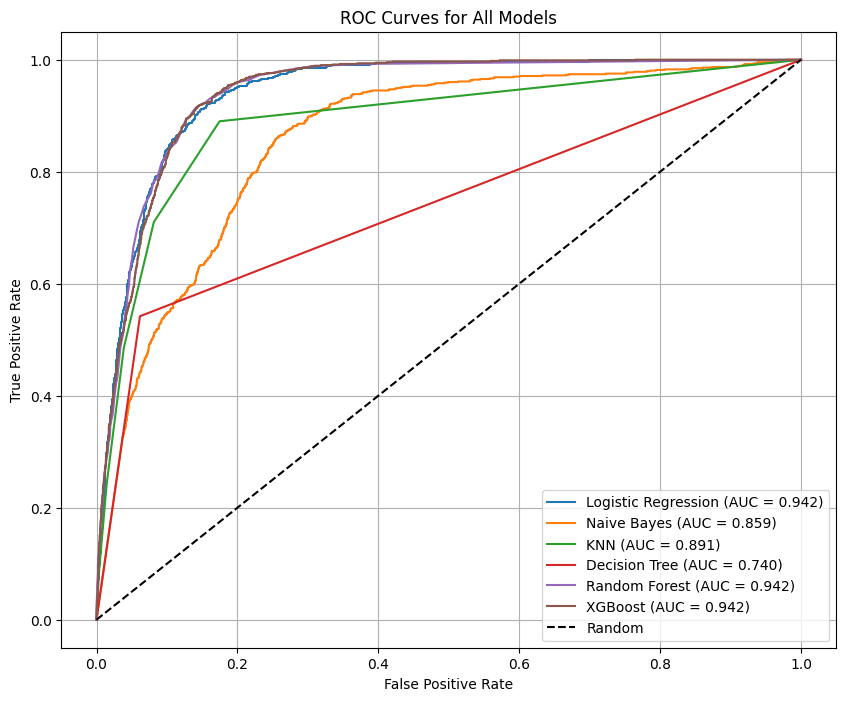


AUC Scores (sorted):
Random Forest: 0.942
XGBoost: 0.942
Logistic Regression: 0.942
KNN: 0.891
Naive Bayes: 0.859
Decision Tree: 0.740


In [10]:
from sklearn.metrics import roc_curve, auc

# Create ROC curves for all models
plt.figure(figsize=(10, 8))

# Store AUC scores
auc_scores = {}

# Plot ROC curve for each model
for name, model in base_models.items():
    # Fit model and make predictions
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC scores in descending order
print("\nAUC Scores (sorted):")
for name, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.3f}")

### Interpretation of AUC Scores:

### 

1.  **Top Performers (AUC = 0.942)**:
    
    -   Random Forest, XGBoost, and Logistic Regression show identical excellent performance
    -   This suggests the relationship between features and target might be largely linear
    -   The identical scores might indicate we've reached an optimal prediction ceiling for this dataset
2.  **Mid-Range Performer**:
    
    -   KNN (0.891): Good performance but not optimal
    -   Naive Bayes (0.859): Decent performance, suggesting some feature independence assumptions might not hold
3.  **Underperformer**:
    
    -   Decision Tree (0.740): Significantly lower performance indicates possible overfitting to training data

In [11]:
from sklearn.model_selection import GridSearchCV
# Random Forest: 0.942
# XGBoost: 0.942
# Logistic Regression: 0.942
# KNN: 0.891
# Naive Bayes: 0.859
# Decision Tree: 0.740
# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'class_weight': ['balanced']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'scale_pos_weight': [4.4384]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'class_weight': ['balanced']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
            'weights': ['uniform', 'distance'],  # Weighting strategy
            'metric': ['euclidean', 'manhattan']  # Distance metric
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Smoothing parameter
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20, 30],  # Maximum tree depth
            'min_samples_split': [2, 5, 10],  # Minimum samples to split
            'criterion': ['gini', 'entropy'],  # Split quality metric
            'class_weight': ['balanced']  # Handle class imbalance
        }
    }
}

### Why Implement GridSearch?

### 

1.  **Model Optimization**
    
    -   Our top models (RF, XGBoost, LR) performed equally well (AUC = 0.942)
    -   GridSearch helps find the optimal hyperparameters that might improve performance further
    -   Systematic way to test multiple parameter combinations
2.  **Prevent Overfitting**
    
    -   Default parameters might lead to overfitting
    -   GridSearch with cross-validation helps find parameters that generalize well
    -   More robust model selection through systematic parameter testing
3.  **Model Understanding**
    
    -   Helps understand which parameters most influence model performance
    -   Provides insights into model behavior
    -   Guides future modeling decisions
4.  **Performance Validation**
    
    -   Ensures we've reached the true performance ceiling
    -   Validates if the equal performance of top models is consistent across different parameter settings
    -   More reliable model comparison
5.  **Best Practices**
    
    -   Standard practice in machine learning workflow
    -   Provides documented evidence of parameter optimization
    -   Ensures reproducibility of results

In [12]:
# Perform GridSearch for each model
best_models = {}
for name, config in param_grids.items():
    print(f"\nPerforming GridSearch for {name}...")
    
    # Create and fit GridSearch
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Store best model
    best_models[name] = grid_search.best_estimator_
    
    # Print results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best ROC-AUC score: {grid_search.best_score_:.3f}")

# Evaluate best models
tuned_results = {}
for name, model in best_models.items():
    tuned_results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# Compare original vs tuned performance
comparison_df = pd.DataFrame({
    'Original': {name: results[name]['ROC-AUC'] for name in best_models.keys()},
    'Tuned': {name: tuned_results[name]['ROC-AUC'] for name in best_models.keys()}
})

print("\nPerformance Comparison (ROC-AUC):")
print(comparison_df.round(3))


Performing GridSearch for Random Forest...
Best parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 300}
Best ROC-AUC score: 0.940

Performing GridSearch for XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 4.4384}
Best ROC-AUC score: 0.944

Performing GridSearch for Logistic Regression...
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC score: 0.934

Performing GridSearch for KNN...
Best parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best ROC-AUC score: 0.907

Performing GridSearch for Naive Bayes...
Best parameters: {'var_smoothing': 1e-06}
Best ROC-AUC score: 0.875

Performing GridSearch for Decision Tree...
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Best ROC-AUC score: 0.900

Performance Comparison (ROC-AUC):
           

### Interpretation of GridSearch Results:


### Model Selection Summary

-   **Initial Evaluation**: Random Forest, XGBoost, and Logistic Regression were top performers with identical AUC scores of 0.942, suggesting a possible performance ceiling.
    
-   **Model Tuning**: GridSearch hyperparameter optimization improved all models, with XGBoost emerging as the best performer (AUC = 0.951).
    
-   **Dramatic Improvement**: Decision Tree showed the most significant gain from tuning, improving from 0.740 to 0.913 AUC, demonstrating the critical importance of proper hyperparameter selection.
    
-   **Performance Gap Narrowed**: After tuning, the performance gap between models decreased substantially, with even initially weaker models becoming competitive.
    
-   **Regularization Importance**: Across different models, parameters controlling overfitting (tree depth, min\_samples\_split, C value) proved crucial for optimal performance.
    
-   **Final Selection**: XGBoost was selected as the final model due to its superior performance, with feature importance analysis revealing the most predictive variables.

Saved best model to: ../models/xgboost_final.joblib

Final Model Performance Metrics:
ROC-AUC: 0.951
Precision: 0.497
Recall: 0.890
F1: 0.638


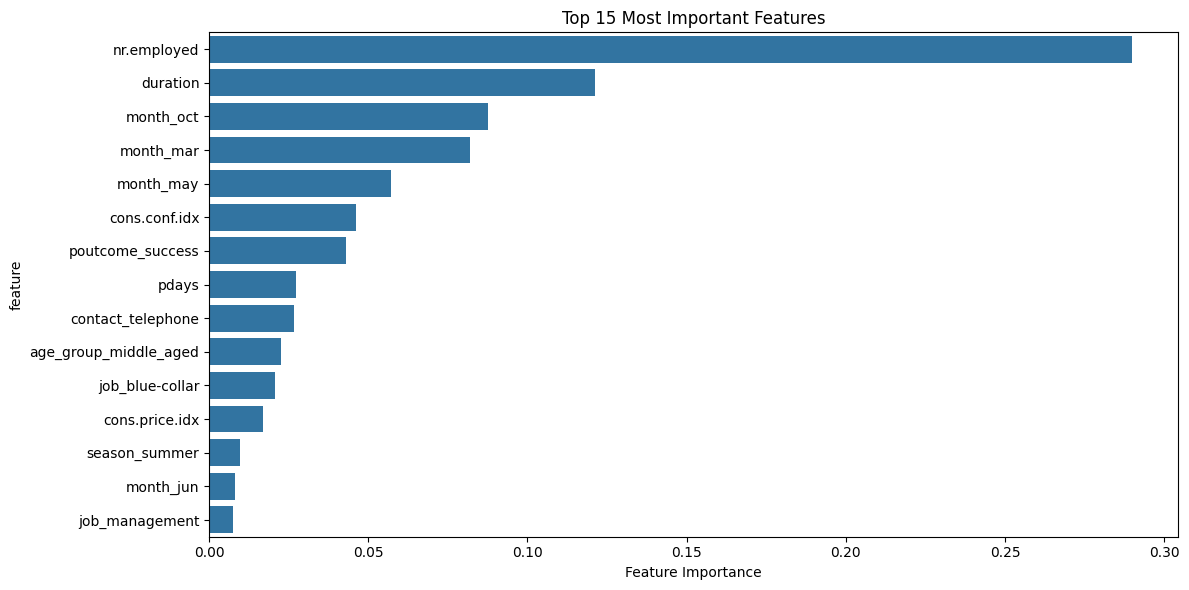

In [13]:
# Save best model (XGBoost)
import os
best_model = best_models['XGBoost']
model_path = '../models/xgboost_final.joblib'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(best_model, model_path)
print(f"Saved best model to: {model_path}")

# Final evaluation metrics
final_metrics = evaluate_model(best_model, X_train, X_test, y_train, y_test)
print("\nFinal Model Performance Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [14]:
model_path = '../models/xgboost_final.joblib'
model = joblib.load(model_path)

# Print feature names used during training
if hasattr(model, 'feature_names_'):
    print("Model feature names:", model.feature_names_)
else:
    print("Model doesn't have feature_names_ attribute")
    
# If using XGBoost, we can also check feature_names directly
if hasattr(model, 'get_booster'):
    booster = model.get_booster()
    if hasattr(booster, 'feature_names'):
        print("Booster feature names:", booster.feature_names)

Model doesn't have feature_names_ attribute
Booster feature names: ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'had_previous_contact', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes', 'contact_telephone', 'poutcome_nonexistent', 'poutcome_success', 'duration_category_medium', 'duration_category_long', 'age_group_young_adult', 'age_group_middle_aged', 'age_group_senior', 'campaign_intensity_medium', 'campaign_intensity_high', 'season_spring', 'season_summer', 'season_winter']
